In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.abspath('../../')
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    # torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")

device = 'cpu'
%load_ext autoreload
%autoreload 2

4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40


In [2]:
kernel = torch.load('../final_kernel.pt',map_location=device).requires_grad_(False)

undisp_cube = torch.tensor(np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_mask_analysis_exptime_6250_us/gtcube.npy')).to(device)
undisp_cube, spectras = hlp.create_bs_data(desired_channels=41,desired_range=[725,875], cube = undisp_cube, fts_dir = '20230906_1grating_mask_data_exptime_6250_us', cube_dir = '20230830_mask_analysis_talbot0_exptime_190_us',interp_type='average',device=device) #here we'll work with synthetic data. 


batch_size = 2

batch_size = 2

cropsize = [500, 640]

dataset = hlp.SyntheticDataset(undispersed_cube=undisp_cube,shift_info={'kernel':kernel}, spectra = spectras, crop=cropsize, random_shifts=False)


collecting the undispersed cube and spectra.


In [3]:
batch_size = 2
torch.cuda.empty_cache()

allindexes = np.arange(len(dataset))
np.random.shuffle(allindexes)
tr_indexes = allindexes[:int(0.05*len(allindexes))]
v_indexes = allindexes[int(0.05*len(allindexes)):int(0.06*len(allindexes))] 

# Create a data loader for batch processing
tr_loader = hlp.CustomDataLoader(dataset, tr_indexes, batch_size=batch_size, shuffle=True)
v_loader = hlp.CustomDataLoader(dataset, v_indexes, batch_size=batch_size, shuffle=True)


## Test a model I trained on all the data (using train_model.py)

In [4]:
model = FourierDenoiser(kernel=kernel,CoordGate=False, channels=41, cropsize=cropsize).to(device)
# model.load_state_dict(torch.load('fourier_denoiser_b')); #trained on all data.
model.load_state_dict(torch.load('../syn')); #trained on all data.
model.eval();

In [5]:
# %%timeit

indexes = [600,800]
(x,y) = dataset[indexes]
y_pred = model(x)

Text(0.5, 1.0, 'Original')

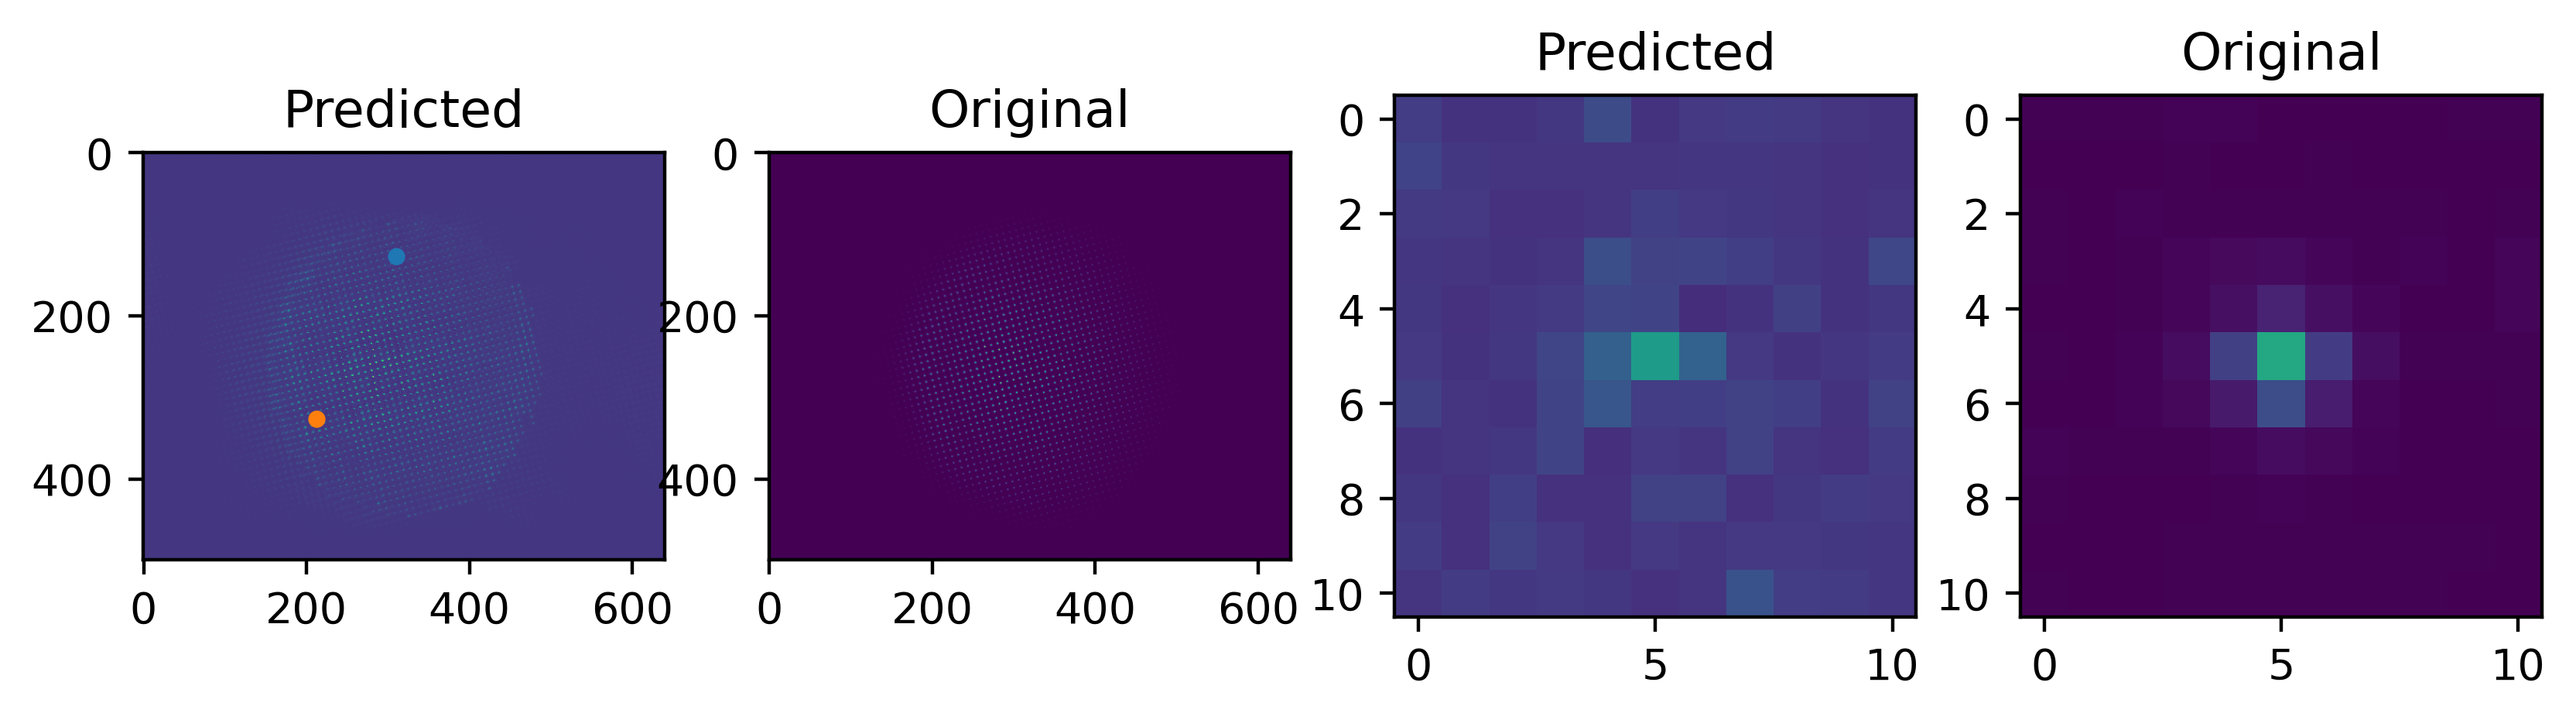

In [6]:
fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=400)
ax[0].imshow(y_pred[0,10].cpu().detach().numpy()); ax[0].set_title('Predicted')
ax[1].imshow(y[0,10].cpu().detach().numpy())    ; ax[1].set_title('Original')

coords1 = [127,310]
boxsize = 5

coords2 = [326,212]

ax[0].plot(coords1[1],coords1[0],'.')

ax[0].plot(coords2[1],coords2[0],'.')

coords = coords2

ax[2].imshow(y_pred[0,10,coords[0]-boxsize:coords[0]+boxsize+1,coords[1]-boxsize:coords[1]+boxsize+1].cpu().detach().numpy(),vmax = y_pred[0,10].cpu().detach().numpy().max(),vmin = y_pred[0,10].cpu().detach().numpy().min()); ax[2].set_title('Predicted')
ax[3].imshow(y[0,10,coords[0]-boxsize:coords[0]+boxsize+1,coords[1]-boxsize:coords[1]+boxsize+1].cpu().detach().numpy(),vmax = y[0,10].cpu().detach().numpy().max(),vmin = y[0,10].cpu().detach().numpy().min())   ; ax[3].set_title('Original')

Text(0.5, 1.0, 'Original')

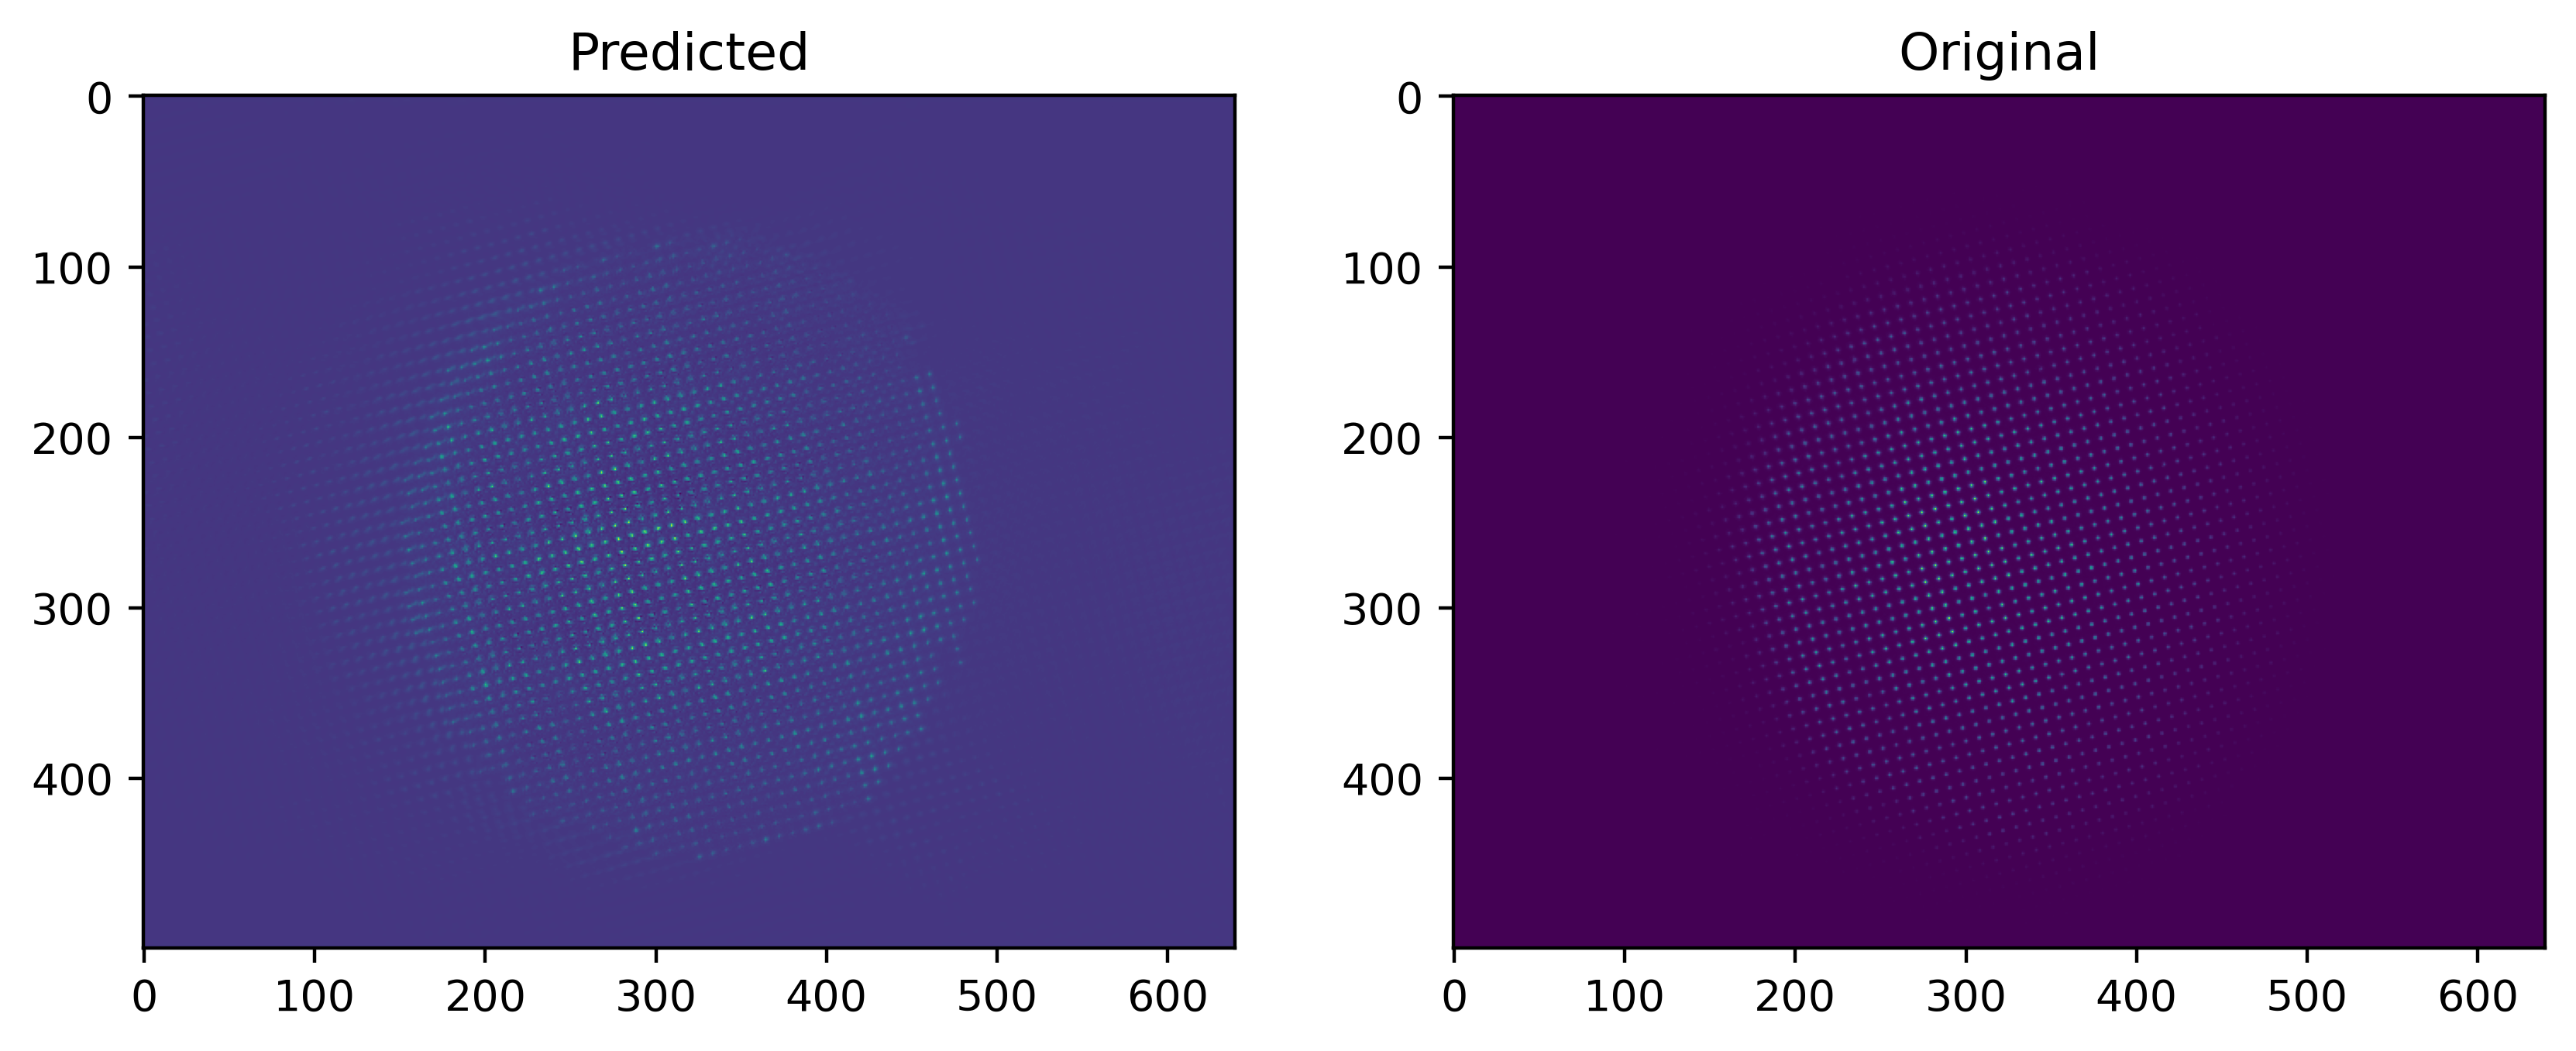

In [7]:
fig,ax = plt.subplots(1,2,figsize=(10,5),dpi=400)
ax[0].imshow(y_pred[0,10].cpu().detach().numpy()); ax[0].set_title('Predicted')
ax[1].imshow(y[0,10].cpu().detach().numpy())    ; ax[1].set_title('Original')

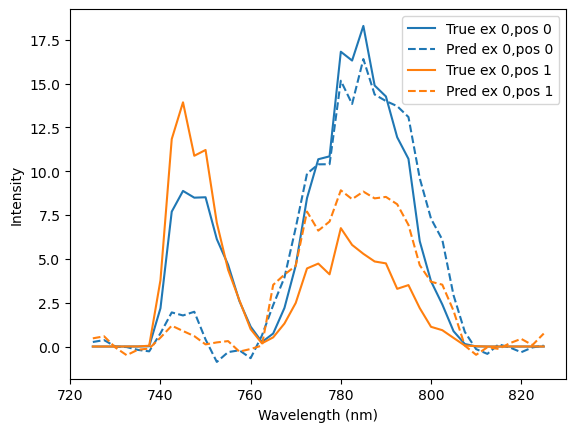

In [8]:
wls = np.linspace(725,825,41)

fig = plt.figure()
ax = fig.add_subplot(111)
j=0

coords = [coords1,coords2]

for i in range(2):
        line, = ax.plot(wls,y[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),label=   f'True ex {j},pos {i}')
        ax.plot(wls,y_pred[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred ex {j},pos {i}')


ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
plt.legend()

In [9]:
x_syn, y_syn = x.clone(), y.clone()

In [10]:
angle = -0.1527883832038498
shifted_undisp_cube = undisp_cube # torch.roll(undisp_cube, dims=(2,3), shifts=(-1,2))


dataset = hlp.FTSDataset(undispersed_cube=shifted_undisp_cube, spectra = spectras,dir = '20230804_1grating_mask_data_exptime_2400_us',  crop=cropsize, random_shifts=False, angle=angle)




In [11]:
indexes = [600,1300]
(x,y) = dataset[indexes]
y_pred = model(x)

In [12]:
x.mean() * 2**12

tensor(162.5266)

In [13]:
x.max(),x.mean(),x.min(), x_syn.max(),x_syn.mean(),x_syn.min(), y.max(),y.mean(),y.min()

(tensor(10.0505),
 tensor(0.0397),
 tensor(0.),
 tensor(10.6606),
 tensor(0.0230),
 tensor(-9.6642e-08),
 tensor(216.3096),
 tensor(0.2666),
 tensor(0.))

Text(0.5, 1.0, 'Original')

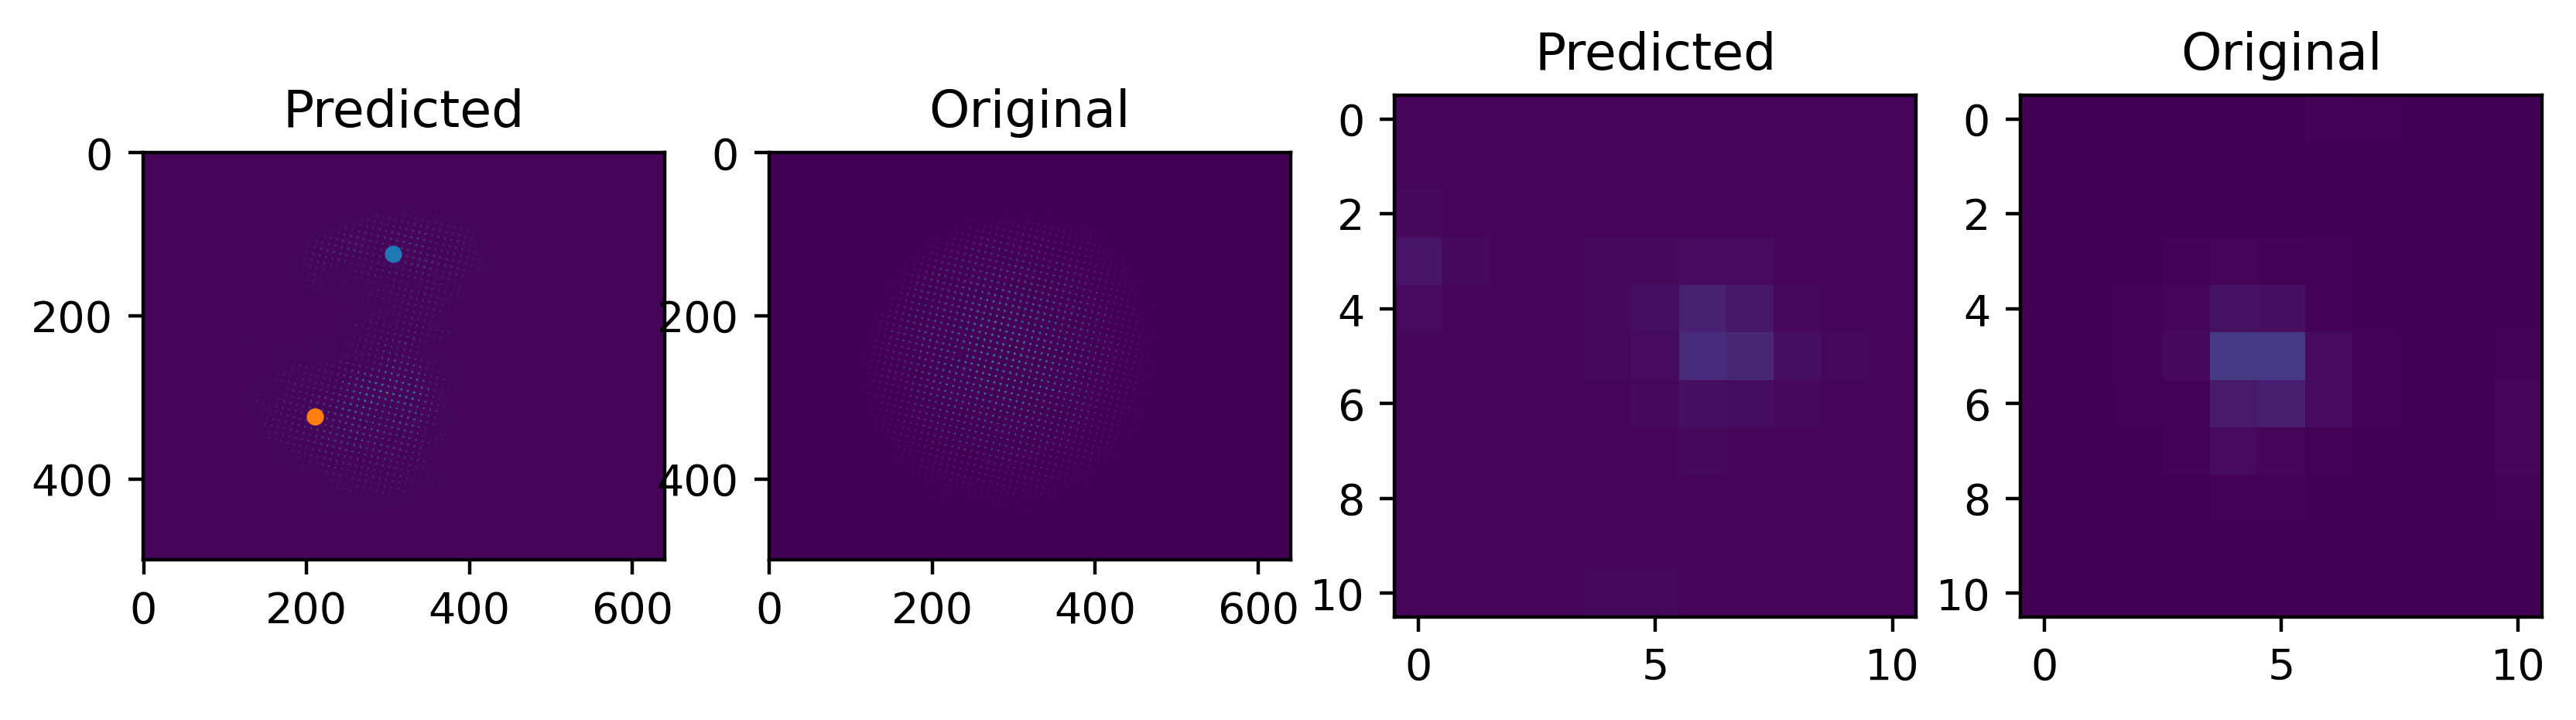

In [14]:
fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=400)
ax[0].imshow(y_pred[0,10].cpu().detach().numpy()); ax[0].set_title('Predicted')
ax[1].imshow(y[0,10].cpu().detach().numpy())    ; ax[1].set_title('Original')

coords1 = [124,306]
boxsize = 5

coords2 = [323,210]

ax[0].plot(coords1[1],coords1[0],'.')

ax[0].plot(coords2[1],coords2[0],'.')

coords = coords1

ax[2].imshow(y_pred[0,10,coords[0]-boxsize:coords[0]+boxsize+1,coords[1]-boxsize:coords[1]+boxsize+1].cpu().detach().numpy(),vmax = y_pred[0,10].cpu().detach().numpy().max(),vmin = y_pred[0,10].cpu().detach().numpy().min()); ax[2].set_title('Predicted')
ax[3].imshow(y[0,10,coords[0]-boxsize:coords[0]+boxsize+1,coords[1]-boxsize:coords[1]+boxsize+1].cpu().detach().numpy(),vmax = y[0,10].cpu().detach().numpy().max(),vmin = y[0,10].cpu().detach().numpy().min())   ; ax[3].set_title('Original')

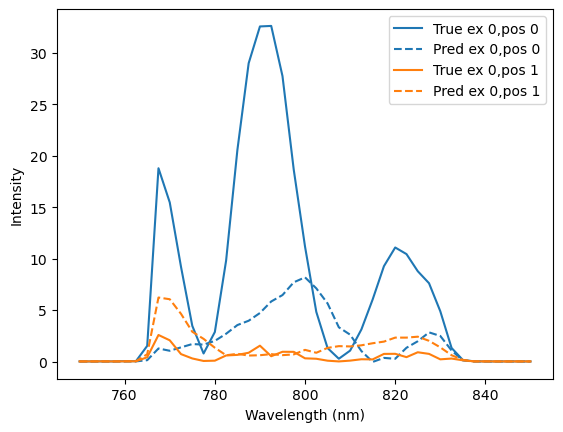

In [15]:
wls = np.linspace(750,850,41)

fig = plt.figure()
ax = fig.add_subplot(111)
j=0

coords = [coords1,coords2]

for i in range(2):
        line, = ax.plot(wls,y[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),label=   f'True ex {j},pos {i}')
        ax.plot(wls,y_pred[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred ex {j},pos {i}')


ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
plt.legend()

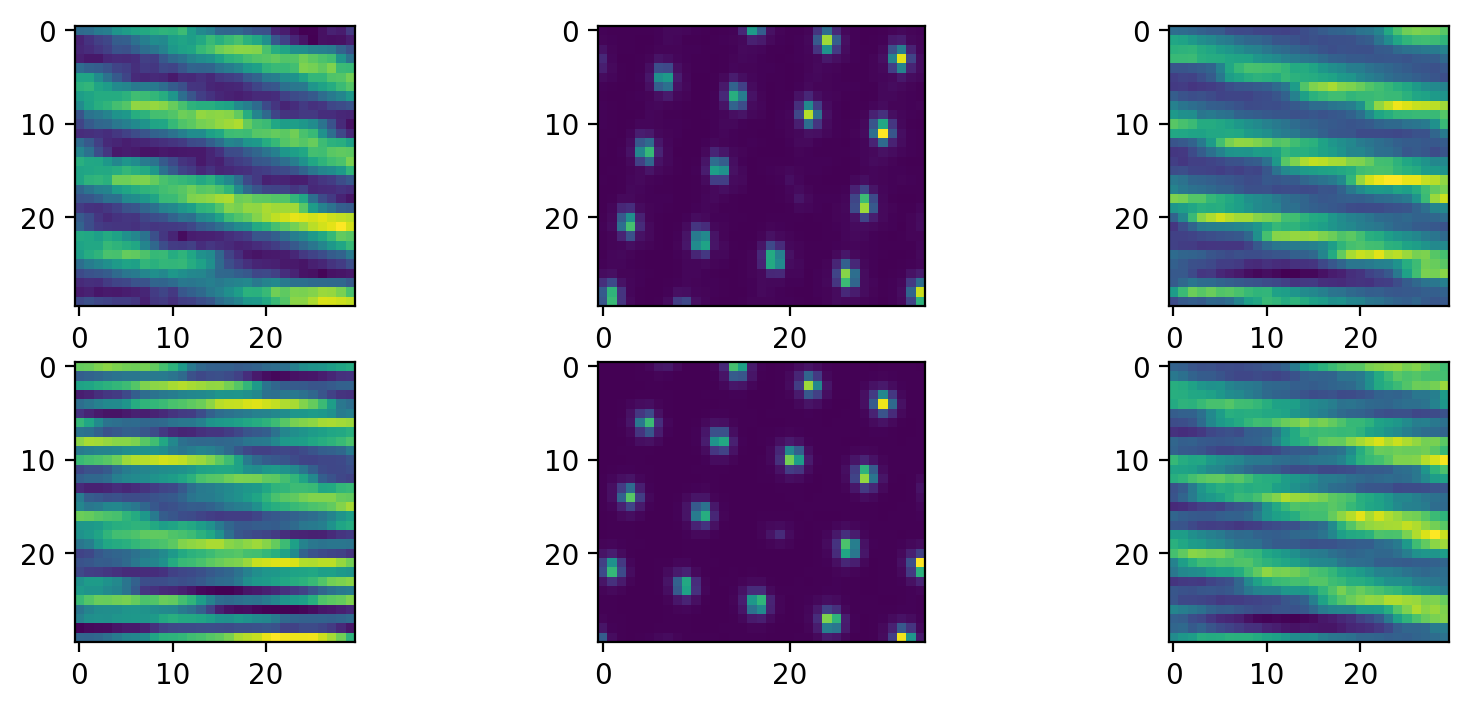

In [16]:
fig,ax = plt.subplots(2,3,figsize = (10,4),dpi=200)

a = [220,250]
b = [250,280]

ax[0,0].imshow(x[0,a[0]:a[1],b[0]:b[1]].cpu().numpy())
ax[1,0].imshow(x_syn[0,a[0]:a[1],b[0]:b[1]].cpu().numpy())

# a = [220,250]
# b = [1000,1030]
a = [230,260]
b = [1120,1155]

ax[0,1].imshow(x[0,a[0]:a[1],b[0]:b[1]].cpu().numpy())
ax[1,1].imshow(x_syn[0,a[0]:a[1],b[0]:b[1]].cpu().numpy())

a = [220,250]
b = [2050,2080]

ax[0,2].imshow(x[0,a[0]:a[1],b[0]:b[1]].cpu().numpy())
ax[1,2].imshow(x_syn[0,a[0]:a[1],b[0]:b[1]].cpu().numpy())

### Check alignment

In [20]:
dataset = hlp.SyntheticDataset(undispersed_cube=shifted_undisp_cube,shift_info={'kernel':kernel}, spectra = spectras, crop=False)
indexes = [600,800]
(x,y) = dataset[indexes]

In [18]:
dataset = hlp.FTSDataset(undispersed_cube=shifted_undisp_cube, spectra = spectras,dir = '20230804_1grating_mask_data_exptime_2400_us',  crop=cropsize, random_shifts=False, angle=angle)
indexes = [600,800]
(x_syn,y_syn) = dataset[indexes]

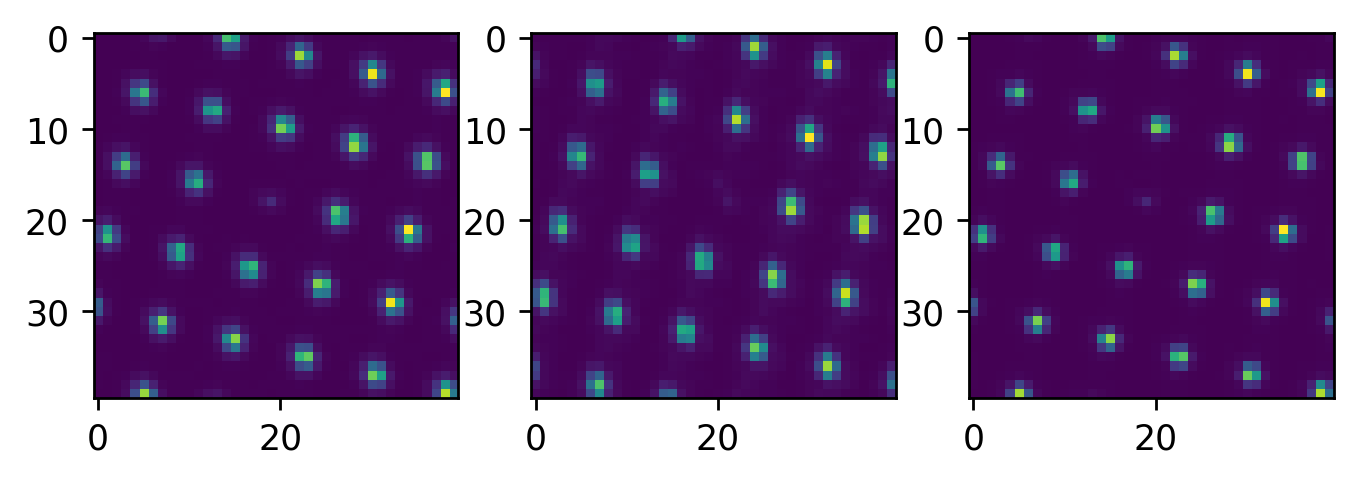

In [21]:
fig,ax  = plt.subplots(1,3,dpi=250)
ax[0].imshow(x[0,230:270,1120:1160]);
ax[1].imshow(x_syn[0,230:270,1120:1160]);
ax[2].imshow(torch.sum(y[0,:,230:270,1120:1160],dim=0));

In [23]:
y.shape

torch.Size([2, 41, 500, 640])